In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

This ipython notebook will illustrate the matching methodology we will use to match patients in the SEER-Medicare linked database. The comparison between patient outcomes between those patients who receive proton beam therapy vs traditional radiation therapy requires as a first step a matching of the two different groups. One method to perform this matching is to use Propensity Score Matching. Here we are going to illustrate a more direct method of matching using KDTrees, a data structure that allows for efficient finding of nearest neighbors in high-dimenional space. 

In [2]:
import seerhelp

In [3]:
breastfiles = seerhelp.get_breastfiles()
breastfiles

['SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\BREAST.TXT',
 'inSEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\BREAST.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\BREAST.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\BREAST.txt']

In [4]:

dfbreast0 = seerhelp.make_clean_dataframe(breastfiles[0])

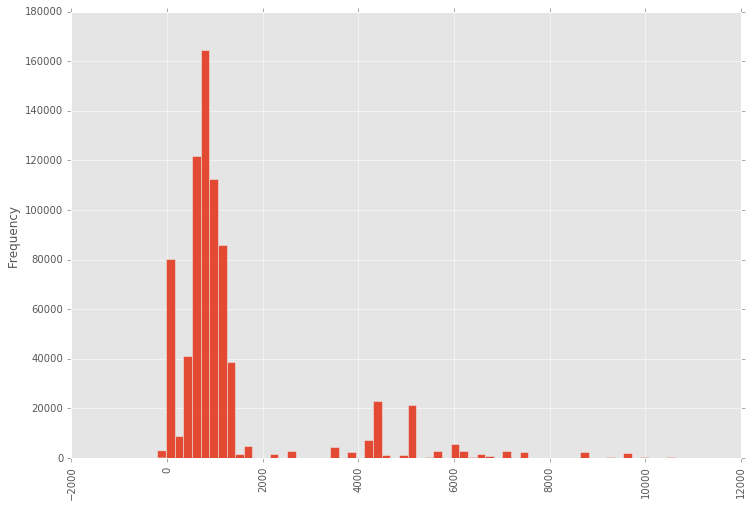

In [6]:
dfbreast0['elevation'].plot(kind='hist',bins=60,rot=90,figsize=((12,8)));

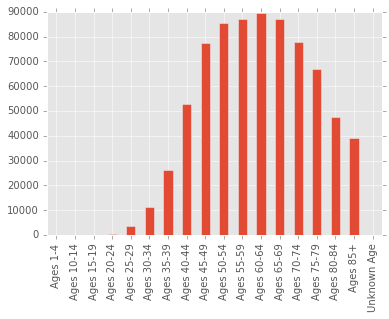

In [7]:
dfbreast0['AGE_1REC'].value_counts().sort_index().plot(kind='bar',rot=90);

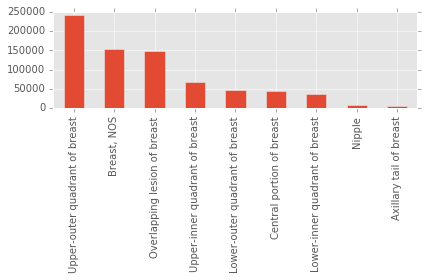

In [9]:
dfbreast0['PRIMSITE'].value_counts().plot(kind='bar',rot=90);
plt.tight_layout()

## One-Hot Encode the categorical variables we wish to include 

In order to find the neighbors in the high-dimensional feature space, we need to first do some preprocessing on the data.
The first step is to "one-hot encode" the categorical features.

In [80]:
mask = (dfbreast0['CSTUMSIZ'] != "Unknown; size not stated; not stated in patient record") & \
 (dfbreast0['CSTUMSIZ'] != "Microscopic focus or foci only; no size of focus is given") & \
 (dfbreast0['CSTUMSIZ'] != "989 millimeters or larger") & \
 (dfbreast0['CSTUMSIZ'] != "Not applicable") & \
 (dfbreast0['AGE_DX'] != "Unknown age") & \
 (dfbreast0['srv_time_mon_flag'] == "Complete dates are available and there are more than 0 days of survival") & \
 (dfbreast0['REC_NO'] == 1) & \
 (dfbreast0['YEAR_DX'] >= 2004) & \
 (dfbreast0['CSTUMSIZ'] != "Described as less than 1 cm") & \
(dfbreast0['CSTUMSIZ'] != "Described as less than 2 cm") & \
(dfbreast0['CSTUMSIZ'] != "Described as less than 3 cm") & \
(dfbreast0['CSTUMSIZ'] != 'Indicates no msas or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfbreast0['CSTUMSIZ'] != "Described as less than 4 cm") & \
(dfbreast0['CSTUMSIZ'] != "Described as less than 5 cm") & \
(dfbreast0['CSTUMSIZ'] != "Not applicable") & \
(dfbreast0['YR_BRTH'] != 'Unknown year of birth') & \
(dfbreast0['CSTUMSIZ'] != 'Not applicable') & \
(dfbreast0['CSTUMSIZ'] != 996) & \
(dfbreast0['CSTUMSIZ'] != 997) & \
(dfbreast0['CSTUMSIZ'] != 998)

In [104]:
dfsmall = dfbreast0[mask].copy()

In [105]:
dfsmall.set_index('PUBCSNUM',inplace=True)

In [106]:
dfsmall.shape

(182509, 140)

In [107]:
dfsmall['RADIATN'].value_counts()

Beam radiation                                                              94086
None; diagnosed at autopsy                                                  74318
Radiation recommended, unknown if administered                               4845
Radioactive implants                                                         4560
Patient or patient's guardian refused radiation therapy                      2560
Radiation, NOS - method or source not provided                               1337
Combination of beam radiation with radioactive implants or radioisotopes      352
Unknown if radiation administered                                             340
Radioisotopes                                                                 111
Name: RADIATN, dtype: int64

## Treatment and Control group defintions

Lets consider ```(dfsmall.RADIATN == "Beam radiation")``` as the **treatment** group and
```(dfsmall.RADIATN == "None; diagnosed at autopsy")``` as the **control** group. We need to find the matching patients where one is one of these groups and one is in the other. 

In [108]:
catcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC','RADIATN']

In [109]:
goodcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC','RADIATN',
           'YR_BRTH','AGE_DX','YEAR_DX','CSTUMSIZ',
           'elevation','lat','lng']

In [110]:
resgood = pd.concat([pd.get_dummies(dfsmall[col],prefix=col) for col in catcols], axis=1)

In [111]:
resgood['YR_BRTH'] = dfsmall['YR_BRTH']
#resgood['number_of_primaries'] = dfsmall['number_of_primaries']
resgood['AGE_DX'] = dfsmall['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgood['YEAR_DX'] = dfsmall['YEAR_DX']
#resgood['cs_tumor_size_ext_eval'] = dfsmall['cs_tumor_size_ext_eval']
resgood['CSTUMSIZ'] = dfsmall['CSTUMSIZ']
#resgood['REC_NO'] = dfsmall['REC_NO']
resgood['elevation'] = dfsmall['elevation']
resgood['lat'] = dfsmall['lat']
resgood['lng'] = dfsmall['lng']
#resgood['month_of_diagnosis'] = dfsmall['number_month_of_diagnosis']
#resgood['PUBCSNUM'] = dfsmall['PUBCSNUM']
resgood['srv_time_mon'] = dfsmall['srv_time_mon']
resgood['RADIATN'] = dfsmall['RADIATN']



print(resgood.shape)

(182509, 126)


In [112]:
resgood['STAT_REC_Dead'].value_counts()

0.0    159887
1.0     22622
Name: STAT_REC_Dead, dtype: int64

After performing the matching betweent the control and treatment groups, we will see how is more likely to be dead.

In [113]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

T = resgood["srv_time_mon"]
E = resgood["STAT_REC_Dead"]

kmf.fit(T, event_observed=E);

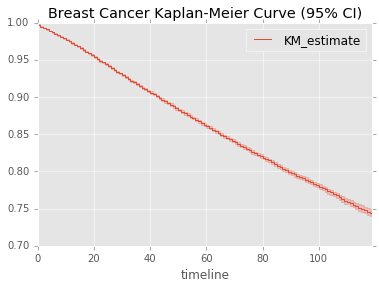

In [114]:
kmf.plot()
plt.title("Breast Cancer Kaplan-Meier Curve (95% CI)");

In [115]:
resgood['YR_BRTH'] = resgood['YR_BRTH'].astype('int')
resgood['AGE_DX'] = resgood['AGE_DX'].astype('int')
resgood['CSTUMSIZ'] = resgood['CSTUMSIZ'].astype('float')
resgood['elevation'] = resgood['elevation'].astype('float')
resgood['lat'] = resgood['lat'].astype('float')
resgood['lng'] = resgood['lng'].astype('float')
resgood['srv_time_mon'] = resgood['srv_time_mon'].astype('float')

In [116]:
with pd.option_context('display.max_rows', 999, 'display.max_columns', 3):
    print(resgood.dtypes)

SEX_Female                                                                                                                   float64
SEX_Male                                                                                                                     float64
MAR_STAT_Divorced                                                                                                            float64
MAR_STAT_Married (including common law)                                                                                      float64
MAR_STAT_Separated                                                                                                           float64
MAR_STAT_Single (never married)                                                                                              float64
MAR_STAT_Unknown                                                                                                             float64
MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or u

In [123]:
newcolumns = list(resgood.columns)

In [124]:
list(newcolumns)

['SEX_Female',
 'SEX_Male',
 'MAR_STAT_Divorced',
 'MAR_STAT_Married (including common law)',
 'MAR_STAT_Separated',
 'MAR_STAT_Single (never married)',
 'MAR_STAT_Unknown',
 'MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered)',
 'MAR_STAT_Widowed',
 'RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)',
 'RACEIV_Asian Indian',
 'RACEIV_Asian Indian or Pakistani, NOS',
 'RACEIV_Black',
 'RACEIV_Chamorran',
 'RACEIV_Chinese',
 'RACEIV_Fiji Islander',
 'RACEIV_Filipino',
 'RACEIV_Guamanian, NOS',
 'RACEIV_Hawaiian',
 'RACEIV_Hmong',
 'RACEIV_Japanese',
 'RACEIV_Kampuchean (including Khmer and Cambodian)',
 'RACEIV_Korean',
 'RACEIV_Laotian',
 'RACEIV_Melanesian, NOS',
 'RACEIV_Micronesian, NOS',
 'RACEIV_New Guinean',
 'RACEIV_Other',
 'RACEIV_Other Asian, including Asian, NOS and Oriental NOS',
 'RACEIV_Pacific Islander, NOS',
 'RACEIV_Pakistani',
 'RACEIV_Polynesian, NOS',
 'RACEIV_Samo

In [125]:
newcolumns.remove('srv_time_mon')
newcolumns.remove('STAT_REC_Alive')
newcolumns.remove('STAT_REC_Dead')
newcolumns.remove('SEX_Female')
newcolumns.remove('RADIATN_Beam radiation')
newcolumns.remove("RADIATN_Patient or patient's guardian refused radiation therapy")
newcolumns.remove('RADIATN_Radiation recommended, unknown if administered')
newcolumns.remove('RADIATN_Radiation, NOS - method or source not provided')
newcolumns.remove('RADIATN_Radioactive implants')
newcolumns.remove('RADIATN_Radioisotopes')
newcolumns.remove('RADIATN_Unknown if radiation administered')
newcolumns.remove('RADIATN')
newcolumns.remove('RADIATN_Combination of beam radiation with radioactive implants or radioisotopes')

So the column ```RADIATN_None; diagnosed at autopsy``` is what will define our treamtent (=0) and control (=1) groups.

In [126]:
resgreat = resgood[newcolumns].copy()

In [127]:
resgreat.head()

,SEX_Male,MAR_STAT_Divorced,MAR_STAT_Married (including common law),MAR_STAT_Separated,MAR_STAT_Single (never married),MAR_STAT_Unknown,MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered),MAR_STAT_Widowed,"RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)",RACEIV_Asian Indian,...,MDXRECMP_Oct,MDXRECMP_Sep,RADIATN_None; diagnosed at autopsy,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,elevation,lat,lng
PUBCSNUM,,,,,,,,,,,,,,,,,,,,,
7000091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1946,65,2011,5.0,689.717513,41.841899,-72.378468
7000138,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1926,78,2005,8.0,205.060159,41.518519,-72.046816
7000314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1932,77,2009,3.0,471.480778,41.255965,-73.370870
7000515,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1930,75,2006,12.0,471.480778,41.255965,-73.370870
7000790,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1936,74,2010,42.0,205.060159,41.518519,-72.046816


In [128]:
resgreat['League'] = resgreat['RADIATN_None; diagnosed at autopsy']

In [129]:
resgreat.head()

,SEX_Male,MAR_STAT_Divorced,MAR_STAT_Married (including common law),MAR_STAT_Separated,MAR_STAT_Single (never married),MAR_STAT_Unknown,MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered),MAR_STAT_Widowed,"RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)",RACEIV_Asian Indian,...,MDXRECMP_Sep,RADIATN_None; diagnosed at autopsy,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,elevation,lat,lng,League
PUBCSNUM,,,,,,,,,,,,,,,,,,,,,
7000091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1946,65,2011,5.0,689.717513,41.841899,-72.378468,0.0
7000138,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1926,78,2005,8.0,205.060159,41.518519,-72.046816,1.0
7000314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1932,77,2009,3.0,471.480778,41.255965,-73.370870,0.0
7000515,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1930,75,2006,12.0,471.480778,41.255965,-73.370870,1.0
7000790,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1936,74,2010,42.0,205.060159,41.518519,-72.046816,1.0


In [130]:
del resgreat['RADIATN_None; diagnosed at autopsy']

In [131]:
resgreat.head()

,SEX_Male,MAR_STAT_Divorced,MAR_STAT_Married (including common law),MAR_STAT_Separated,MAR_STAT_Single (never married),MAR_STAT_Unknown,MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered),MAR_STAT_Widowed,"RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)",RACEIV_Asian Indian,...,MDXRECMP_Oct,MDXRECMP_Sep,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,elevation,lat,lng,League
PUBCSNUM,,,,,,,,,,,,,,,,,,,,,
7000091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1946,65,2011,5.0,689.717513,41.841899,-72.378468,0.0
7000138,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1926,78,2005,8.0,205.060159,41.518519,-72.046816,1.0
7000314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1932,77,2009,3.0,471.480778,41.255965,-73.370870,0.0
7000515,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1930,75,2006,12.0,471.480778,41.255965,-73.370870,1.0
7000790,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1936,74,2010,42.0,205.060159,41.518519,-72.046816,1.0


In [133]:
dftree = resgreat.copy()
dftree.columns

Index(['SEX_Male', 'MAR_STAT_Divorced',
       'MAR_STAT_Married (including common law)', 'MAR_STAT_Separated',
       'MAR_STAT_Single (never married)', 'MAR_STAT_Unknown',
       'MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered)',
       'MAR_STAT_Widowed',
       'RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)',
       'RACEIV_Asian Indian',
       ...
       'MDXRECMP_Oct', 'MDXRECMP_Sep', 'YR_BRTH', 'AGE_DX', 'YEAR_DX',
       'CSTUMSIZ', 'elevation', 'lat', 'lng', 'League'],
      dtype='object', length=113)

In [134]:
y = dftree['League'].copy()

In [135]:
del dftree['League']

In [136]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plot
#import psycopg2
import random
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import StratifiedShuffleSplit
import pylab as plot
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn import feature_extraction
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.neural_network import MultilayerPerceptronClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
import pylab as pl
from sklearn.decomposition import RandomizedPCA
from itertools import cycle
from sklearn.cross_validation import ShuffleSplit
from scipy.stats import sem
from pprint import pprint
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import lag_plot

This brute-force method of finding similar matches in this high-dimensional space is possible for this data set as well as for Big Data sized data sets thanks to a data structure called a KDTree. We need to first transform the numeric data so that all of the different features contribute equally to the eulicidean distance between teams. 


For example, **AGE_DX** is on the order of 60 or so, while **YR_BRTH** is around 1960. Without standardzation, **YR_BRTH** would contribute much more heavily to the distance between teams than **AGE_DX**.
The result of standardization (or Z-score normalization) is that the features will be rescaled so that they will have the properties of a standard normal distribution with

$
\mu = 0 \mbox{ and } \sigma = 1
$


where $\mu$ is the mean (averge) and $\sigma$ is the standard deviation from the mean; standard deviation scores 
(also called $z$ scores) are then calculated as follows:

$
z = \frac{x - \mu}{\sigma}
$


In [138]:
xTrain = dftree.values
xTrain = StandardScaler().fit_transform(xTrain)
from sklearn.neighbors import KDTree
print(xTrain)

[[-0.08193246 -0.34561068 -1.12701092 ..., -0.40530442  0.34265996
   1.33513438]
 [-0.08193246 -0.34561068  0.88730285 ..., -0.68477615  0.29002249
   1.34962005]
 [-0.08193246 -0.34561068 -1.12701092 ..., -0.53114796  0.24728589
   1.29178887]
 ..., 
 [-0.08193246 -0.34561068 -1.12701092 ..., -0.28833599 -1.0058654
   0.81114705]
 [-0.08193246 -0.34561068 -1.12701092 ..., -0.23078709 -0.94696262
   0.82680498]
 [-0.08193246 -0.34561068 -1.12701092 ..., -0.23078709 -0.94696262
   0.82680498]]


In [139]:
from sklearn.neighbors import KDTree
kdt = KDTree(xTrain, leaf_size=30)

for i in range(30):
    print(kdt.query_radius(xTrain[i].reshape(1,-1),r=18,count_only=True))

[172595]
[173339]
[173530]
[143152]
[173411]
[168375]
[173772]
[173740]
[173895]
[173854]
[173863]
[173558]
[169833]
[173804]
[174202]
[173789]
[174101]
[174056]
[173889]
[173014]
[172940]
[172841]
[172799]
[173663]
[174304]
[173851]
[173999]
[173837]
[169902]
[173212]


In [140]:
xTrain.shape

(182509, 112)

In [231]:
dftreeleague = dftree.copy()
dftreeleague['League'] = y
dftreeleague.head()

,SEX_Male,MAR_STAT_Divorced,MAR_STAT_Married (including common law),MAR_STAT_Separated,MAR_STAT_Single (never married),MAR_STAT_Unknown,MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered),MAR_STAT_Widowed,"RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)",RACEIV_Asian Indian,...,MDXRECMP_Oct,MDXRECMP_Sep,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,elevation,lat,lng,League
PUBCSNUM,,,,,,,,,,,,,,,,,,,,,
7000091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1946,65,2011,5.0,689.717513,41.841899,-72.378468,0.0
7000138,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1926,78,2005,8.0,205.060159,41.518519,-72.046816,1.0
7000314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1932,77,2009,3.0,471.480778,41.255965,-73.370870,0.0
7000515,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1930,75,2006,12.0,471.480778,41.255965,-73.370870,1.0
7000790,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1936,74,2010,42.0,205.060159,41.518519,-72.046816,1.0


In [232]:
#dftreeleague['newindex'] = range(dftreeleague.shape[0])

In [233]:
#dftreeleague.set_index('newindex',inplace=True, verify_integrity=True)
dftreeleague.head()

,SEX_Male,MAR_STAT_Divorced,MAR_STAT_Married (including common law),MAR_STAT_Separated,MAR_STAT_Single (never married),MAR_STAT_Unknown,MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered),MAR_STAT_Widowed,"RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)",RACEIV_Asian Indian,...,MDXRECMP_Oct,MDXRECMP_Sep,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,elevation,lat,lng,League
PUBCSNUM,,,,,,,,,,,,,,,,,,,,,
7000091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1946,65,2011,5.0,689.717513,41.841899,-72.378468,0.0
7000138,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1926,78,2005,8.0,205.060159,41.518519,-72.046816,1.0
7000314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1932,77,2009,3.0,471.480778,41.255965,-73.370870,0.0
7000515,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1930,75,2006,12.0,471.480778,41.255965,-73.370870,1.0
7000790,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1936,74,2010,42.0,205.060159,41.518519,-72.046816,1.0


In [234]:
dftreeleague.index

Int64Index([ 7000091,  7000138,  7000314,  7000515,  7000790,  7000799,
             7001553,  7004464,  7004709,  7005175,
            ...
            41904546, 41905184, 41905920, 41906137, 41906138, 41906338,
            41906632, 41906810, 41906869, 41907414],
           dtype='int64', name='PUBCSNUM', length=182509)

In [235]:
def get_league(x):
    return dftreeleague['League'].loc[x]

In [143]:
dist4, ind4 = kdt.query(xTrain, k=4, return_distance=True)

In [144]:
ind4

array([[     0,  77139,  10648,  52389],
       [     1,  67528,   8881,  13202],
       [     2,  69673,  72268,  85170],
       ..., 
       [182506, 166654, 166384,  72833],
       [182507, 107831, 109011,  99524],
       [182508,  32507,  35832,  83792]], dtype=int64)

In [145]:
dist4

array([[ 0.        ,  1.33770326,  3.05431226,  3.09477939],
       [ 0.        ,  2.62634728,  3.06087856,  3.37965388],
       [ 0.        ,  1.16386429,  1.3848826 ,  2.85604638],
       ..., 
       [ 0.        ,  2.16247123,  2.67105134,  3.73338673],
       [ 0.        ,  7.12976025,  7.20700065,  7.31712406],
       [ 0.        ,  6.91578205,  7.47223557,  7.77384212]])

In [236]:
dftreeleague['nearest'] = pd.Series(ind4[:,0],index=dftreeleague.index)
dftreeleague['neighbor_1'] = pd.Series(ind4[:,1],index=dftreeleague.index)
dftreeleague['neighbor_2'] = pd.Series(ind4[:,2],index=dftreeleague.index)
dftreeleague['neighbor_3'] = pd.Series(ind4[:,3],index=dftreeleague.index)
dftreeleague['distance_1'] = pd.Series(dist4[:,1],index=dftreeleague.index)
dftreeleague['distance_2'] = pd.Series(dist4[:,2],index=dftreeleague.index)
dftreeleague['distance_3'] = pd.Series(dist4[:,3],index=dftreeleague.index)

In [257]:
dftreeleague.index

Int64Index([ 7000091,  7000138,  7000314,  7000515,  7000790,  7000799,
             7001553,  7004464,  7004709,  7005175,
            ...
            41904546, 41905184, 41905920, 41906137, 41906138, 41906338,
            41906632, 41906810, 41906869, 41907414],
           dtype='int64', name='PUBCSNUM', length=182509)

In [261]:
dfmap = {v: dftreeleague.index[v] for v in range(182509)}
dfmap

{0: 7000091,
 1: 7000138,
 2: 7000314,
 3: 7000515,
 4: 7000790,
 5: 7000799,
 6: 7001553,
 7: 7004464,
 8: 7004709,
 9: 7005175,
 10: 7005909,
 11: 7006066,
 12: 7006264,
 13: 7006364,
 14: 7006495,
 15: 7006716,
 16: 7006856,
 17: 7007363,
 18: 7007527,
 19: 7007798,
 20: 7009243,
 21: 7009395,
 22: 7009626,
 23: 7009666,
 24: 7009949,
 25: 7010190,
 26: 7010553,
 27: 7010913,
 28: 7011183,
 29: 7011385,
 30: 7011950,
 31: 7012150,
 32: 7012536,
 33: 7012575,
 34: 7012689,
 35: 7012848,
 36: 7013221,
 37: 7014321,
 38: 7014448,
 39: 7014563,
 40: 7014791,
 41: 7014858,
 42: 7015041,
 43: 7015112,
 44: 7015659,
 45: 7015803,
 46: 7015970,
 47: 7016355,
 48: 7016536,
 49: 7016543,
 50: 7016563,
 51: 7016732,
 52: 7017221,
 53: 7017263,
 54: 7017353,
 55: 7017465,
 56: 7017507,
 57: 7017712,
 58: 7017804,
 59: 7017834,
 60: 7017914,
 61: 7017943,
 62: 7018186,
 63: 7018297,
 64: 7018564,
 65: 7018593,
 66: 7018631,
 67: 7018851,
 68: 7019091,
 69: 7019610,
 70: 7019611,
 71: 7019612,
 7

In [264]:
len(dfmap)

182509

In [265]:
dftreeleague.shape

(182509, 120)

In [266]:

dftreeleague[['neighbor_1','neighbor_2','neighbor_3']].head()

,neighbor_1,neighbor_2,neighbor_3
PUBCSNUM,,,
7000091,77139,10648,52389
7000138,67528,8881,13202
7000314,69673,72268,85170
7000515,20489,17714,88965
7000790,8586,108459,37506


## Results of the Distance calculations

In [267]:
dftreeleague[['neighbor_1','distance_1',
        'neighbor_2','distance_2',
        'neighbor_3','distance_3']].head(15)

,neighbor_1,distance_1,neighbor_2,distance_2,neighbor_3,distance_3
PUBCSNUM,,,,,,
7000091,77139,1.337703,10648,3.054312,52389,3.094779
7000138,67528,2.626347,8881,3.060879,13202,3.379654
7000314,69673,1.163864,72268,1.384883,85170,2.856046
7000515,20489,2.915635,17714,3.639944,88965,3.878344
7000790,8586,1.755718,108459,2.916528,37506,3.419686
7000799,14510,5.985247,128577,6.127943,35815,6.211703
7001553,48587,0.776962,72196,1.380949,175804,2.464871
7004464,40263,0.918357,40637,0.919131,12238,1.248269
7004709,10841,1.037970,68539,1.086040,71312,1.225407


In [268]:
dftreeleague[['neighbor_1','distance_1',
        'neighbor_2','distance_2',
        'neighbor_3','distance_3']].tail(15)

,neighbor_1,distance_1,neighbor_2,distance_2,neighbor_3,distance_3
PUBCSNUM,,,,,,
41902086,44804,2.725746,174573,3.075856,33538,3.371969
41902107,79122,5.866530,122260,5.995145,64366,6.388002
41902896,29864,5.369116,547,5.389583,9003,5.494070
41904052,177326,1.938438,49057,2.039565,13178,2.180372
41904091,175963,1.504461,174370,1.915453,16237,2.141846
41904546,177419,4.326575,69151,5.294211,19091,5.661782
41905184,182504,5.521383,106827,5.741926,176344,6.730626
41905920,167769,1.619136,168965,1.629472,165775,2.198063
41906137,101436,4.545028,111492,4.790076,108338,4.974285


In [269]:
def get_pubcsnum(x,transformationdict = dfmap):
    return dfmap[x]
    

In [270]:
dftreeleague['neighbor_1'] = dftreeleague['neighbor_1'].apply(get_pubcsnum)
dftreeleague['neighbor_2'] = dftreeleague['neighbor_2'].apply(get_pubcsnum)
dftreeleague['neighbor_3'] = dftreeleague['neighbor_3'].apply(get_pubcsnum)

In [271]:
dftreeleague[['neighbor_1','distance_1',
        'neighbor_2','distance_2',
        'neighbor_3','distance_3']].head(15)

,neighbor_1,distance_1,neighbor_2,distance_2,neighbor_3,distance_3
PUBCSNUM,,,,,,
7000091,28001558,1.337703,11885038,3.054312,20045664,3.094779
7000138,27852617,2.626347,11858716,3.060879,12860003,3.379654
7000314,27886473,1.163864,27922875,1.384883,30190089,2.856046
7000515,12964756,2.915635,12925057,3.639944,4450369,3.878344
7000790,11853931,1.755718,6133123,2.916528,18919081,3.419686
7000799,12880954,5.985247,39213153,6.127943,18892495,6.211703
7001553,19996312,0.776962,27921688,1.380949,41804092,2.464871
7004464,19875382,0.918357,19879397,0.919131,12848436,1.248269
7004709,11888484,1.037970,27870295,1.086040,27902446,1.225407


In [272]:
def get_league(x):
    return dftreeleague['League'].loc[x]

In [273]:
dftreeleague['neighbor_1_League'] = dftreeleague['neighbor_1'].apply(get_league)
dftreeleague['neighbor_2_League'] = dftreeleague['neighbor_2'].apply(get_league)
dftreeleague['neighbor_3_League'] = dftreeleague['neighbor_3'].apply(get_league)

neighbor_1_match = (dftreeleague['neighbor_1_League'] == 0)

one = dftreeleague[['neighbor_1','distance_1',
                  'neighbor_1_League'
        ]][(dftreeleague['neighbor_1_League'] != dftreeleague['League']) & (neighbor_1_match) ].copy()


neighbor_2_match = (dftreeleague['neighbor_2_League'] == 0)

two = dftreeleague[['neighbor_2','distance_2',
                  'neighbor_2_League'
        ]][(dftreeleague['neighbor_2_League'] != dftreeleague['League']) & (neighbor_2_match) ].copy()


neighbor_3_match = (dftreeleague['neighbor_3_League'] == 0)

three = dftreeleague[['neighbor_3','distance_3',
                  'neighbor_3_League'
        ]][(dftreeleague['neighbor_3_League'] != dftreeleague['League']) & (neighbor_3_match) ].copy()

one

,neighbor_1,distance_1,neighbor_1_League
PUBCSNUM,,,
7000138,27852617,2.626347,0.0
7000515,12964756,2.915635,0.0
7000790,11853931,1.755718,0.0
7004709,11888484,1.037970,0.0
7005175,11856154,0.560080,0.0
7006264,18801861,4.502065,0.0
7006495,12851793,0.743812,0.0
7009666,19861762,1.435135,0.0
7010913,19924356,3.356548,0.0


In [275]:
onedict = one['neighbor_1'].to_dict()
twodict = two['neighbor_2'].to_dict()
threedict = three['neighbor_3'].to_dict()

from collections import defaultdict

dd = defaultdict(list)

for d in (onedict, twodict):
    for key, value in d.items():
        dd[key].append(value)
        
        
print(dd)

defaultdict(<class 'list'>, {27918348: [19957073, 35774867], 27918350: [27935997, 19844420], 36962320: [35881979, 36960061], 27918353: [27884673], 34603027: [34702203, 34699988], 41680917: [41751392, 41752843], 39190550: [41793108], 30146583: [30201508], 39190553: [6160721], 41811994: [41727429], 41680923: [18852931, 41785769], 39190556: [39022697], 36962334: [36868712, 27922953], 35826352: [35777662], 30146594: [30158243], 12976167: [12938848, 13026630], 41739382: [11889110, 12877178], 39190577: [39147264], 5374004: [36945257, 27929147], 11818334: [27842028, 13013422], 12976183: [18905169, 12968673], 6201985: [30233090, 41843282], 12845118: [12842676, 12869027], 18824178: [11818630], 35782724: [36900400], 30146632: [19969359], 39190540: [5332300, 6240821], 18918071: [27857551, 12934142], 5374031: [22057425, 6225103], 11796560: [11782812, 18766113], 39168696: [39152197, 39121276], 41680979: [41681985], 30146574: [30189619], 18787001: [11737869], 41680984: [41046201], 12845147: [1891283

In [276]:
goodnoradteams = list(dd.keys())

## Results of Matching

Looking at only the two closest neighbors and matching non-radiation patients to any radiation patients that qualify as being one of the two nearest neighbors, we arrive at the following sets of patients:

In [277]:
goodradteams = list(dd.values())
matches = list(set([item for sublist in goodradteams for item in sublist]))

treatmentindices = goodnoradteams
controlindices = matches
print(treatmentindices)
print(controlindices)

[27918348, 27918350, 36962320, 27918353, 34603027, 41680917, 39190550, 30146583, 39190553, 41811994, 41680923, 39190556, 36962334, 35826352, 30146594, 12976167, 41739382, 39190577, 5374004, 11818334, 12976183, 6201985, 12845118, 18824178, 35782724, 30146632, 39190540, 18918071, 5374031, 11796560, 39168696, 41680979, 30146574, 18787001, 41680984, 12845147, 35782750, 41768293, 36962321, 39197760, 18743411, 41025653, 5374072, 22151293, 12845182, 41025664, 11796609, 12866924, 20054156, 18874510, 30202485, 12845200, 18874513, 18874514, 18743443, 35782806, 11796631, 19923097, 19923099, 41681054, 41025695, 19923104, 6160545, 11796642, 36893051, 18874533, 18874534, 20054183, 41025704, 36984178, 18874543, 20054198, 6160567, 19923129, 19923134, 41047413, 22151361, 12976325, 5374153, 12976333, 41681103, 27940216, 19923157, 5374167, 36962520, 41681114, 27940218, 12845278, 12845280, 6138576, 6182267, 12976356, 4522022, 30146790, 30146791, 35804540, 30146794, 12845291, 19923182, 12976367, 41812208, 

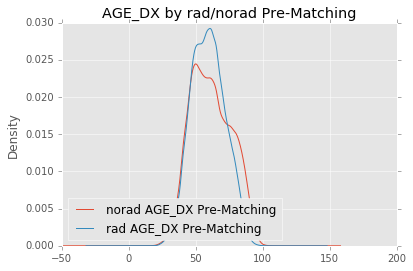

In [278]:
apre = dftreeleague['AGE_DX'][dftreeleague['League'] == 1]
bpre = dftreeleague['AGE_DX'][dftreeleague['League'] == 0]
apost = dftreeleague['AGE_DX'][treatmentindices]
bpost = dftreeleague['AGE_DX'][controlindices]


apre.plot(kind='kde',label='norad AGE_DX Pre-Matching')
bpre.plot(kind='kde',label='rad AGE_DX Pre-Matching')
plt.title('AGE_DX by rad/norad Pre-Matching')
plt.legend(loc=3);

Looks like Doctors don't get radiation to older patients

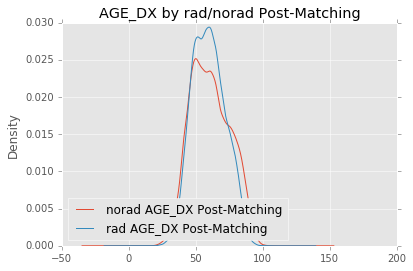

In [279]:
apost.plot(kind='kde',label='norad AGE_DX Post-Matching')
bpost.plot(kind='kde',label='rad AGE_DX Post-Matching')
plt.title('AGE_DX by rad/norad Post-Matching')
plt.legend(loc=3);

In [280]:
def make_pre_post_plots(columnname,df=dftreeleague,splitcolumn='League',
                       treatmentindices=treatmentindices,
                       controlindices=controlindices):
    """Takes a columnname and makes plots of the CDFs for the pre-matching and post-matching as
    well as makes plots of the summaries for the pre and postmatching cases."""
    
    from scipy import stats
    
    ALPOST = df[columnname][treatmentindices].value_counts(normalize=True).sort_index().cumsum()
    NLPOST = df[columnname][controlindices].value_counts(normalize=True).sort_index().cumsum()
    
    dfpost = pd.DataFrame({'NORAD_POST_' + columnname: ALPOST,
                           'RAD_POST_' + columnname: NLPOST})
    
    dfpost = dfpost.fillna(method='ffill')
    
    dfalpostdescribe = df[columnname][treatmentindices].describe()
    dfnlpostdescribe = df[columnname][controlindices].describe()
    
    dfpostdescribe = pd.DataFrame({'NORAD_POST_' + columnname: dfalpostdescribe,
                             'RAD_POST_' + columnname: dfnlpostdescribe})
    
    ALPRE = df[columnname][df[splitcolumn] == 1].value_counts(normalize=True).sort_index().cumsum()
    NLPRE = df[columnname][df[splitcolumn] == 0].value_counts(normalize=True).sort_index().cumsum()
    
    
    
    
    dfpre = pd.DataFrame({'NORAD_PRE_' + columnname: ALPRE,
                       'RAD_PRE_' + columnname: NLPRE})
    
    dfpre = dfpre.fillna(method='ffill')
    
    dfalpredescribe = df[columnname][df[splitcolumn] == 1].describe()
    dfnlpredescribe = df[columnname][df[splitcolumn] == 0].describe()
    
    dfpredescribe = pd.DataFrame({'NORAD_PRE_' + columnname: dfalpredescribe,
                             'RAD_PRE_' + columnname: dfnlpredescribe})
    
    ALPREvals = df[columnname][df[splitcolumn] == 1].values
    NLPREvals = df[columnname][df[splitcolumn] == 0].values
    ALPOSTvals = df[columnname][treatmentindices].values
    NLPOSTvals = df[columnname][controlindices].values
    
    preresults = stats.ks_2samp(ALPREvals, NLPREvals)
    postresults = stats.ks_2samp(ALPOSTvals, NLPOSTvals)
    
    f, axarr = plt.subplots(2,2,figsize=(10,8))
    
    ax = axarr[0, 0]
    titlepre = columnname +  ' cdf pre-matching: \n' + 'ks statistic: ' + \
    str(preresults.statistic) +'\n pvalue: ' + str(preresults.pvalue)
    dfpre.plot(title=titlepre ,ax=ax)
    
    
    titlepost = columnname +  ' cdf post-matching: \n' + 'ks statistic: ' + \
    str(postresults.statistic) +'\n pvalue: ' + str(postresults.pvalue)
    ax = axarr[0,1]
    dfpost.plot(title=titlepost,ax=ax)
    
    
    ax = axarr[1,0]
    ax = dfpredescribe.iloc[1:].plot(kind='bar', title='pre-matching',
                      ax=ax)
    ax.legend(loc='lower right')
    
    ax = axarr[1,1]
    ax = dfpostdescribe.iloc[1:].plot(kind='bar', title='post-matching',
                       ax=ax)
    ax.legend(loc='lower right')

We can see the results of matching by comparing how much closer the distributions of different features are between the treatment group (the NO RAD patients that are matched) and the control group (the corresponding matched RAD patients) (post matching) than are the corresponding distributions for all NON RAD patients as compared to all RAD patients (pre matching). As a metric to compare distributions, use the Kolmogorov-Smirnov statistic on 2 samples. If this K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same (which is what we want in the post matching case).

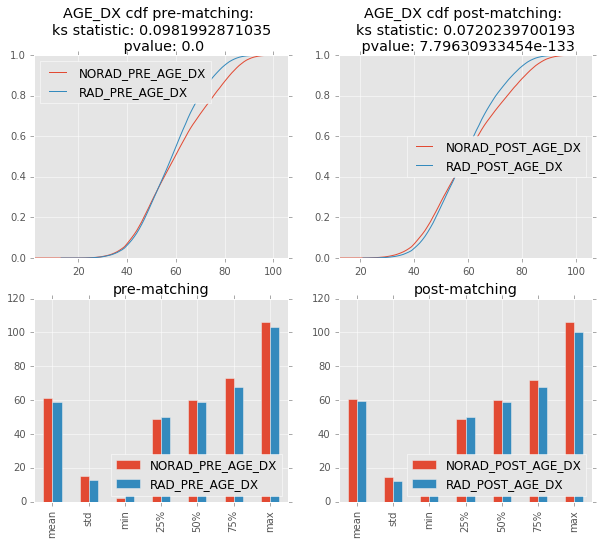

In [281]:
make_pre_post_plots('AGE_DX')

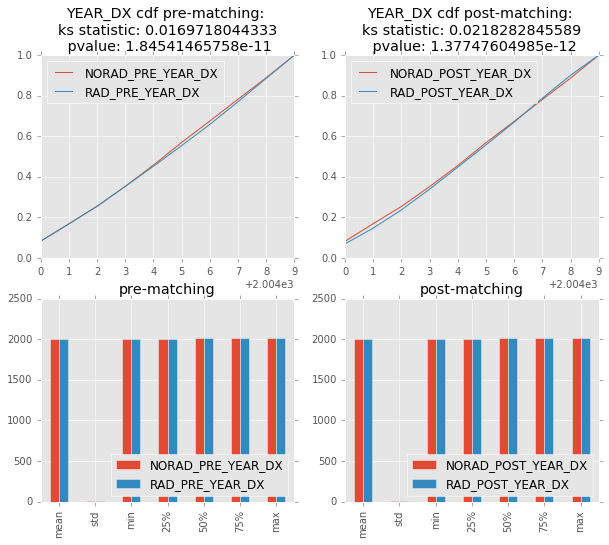

In [282]:
make_pre_post_plots('YEAR_DX')


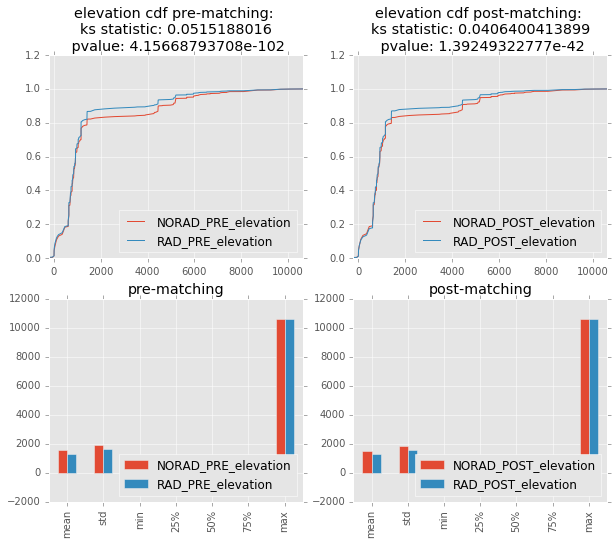

In [283]:
make_pre_post_plots('elevation')

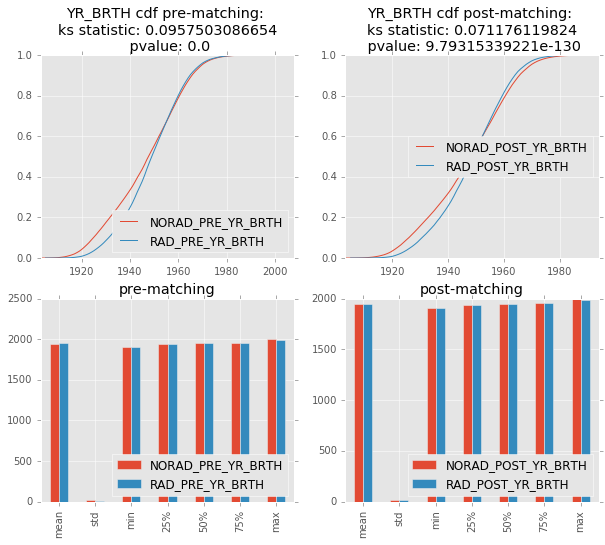

In [284]:
make_pre_post_plots('YR_BRTH')

Need to also do this kind of analysis on the dataframe dfbreast0 before we went nuts and did all the one-hot encoding transformatoins that we can look at the distrubtions of race, etc..

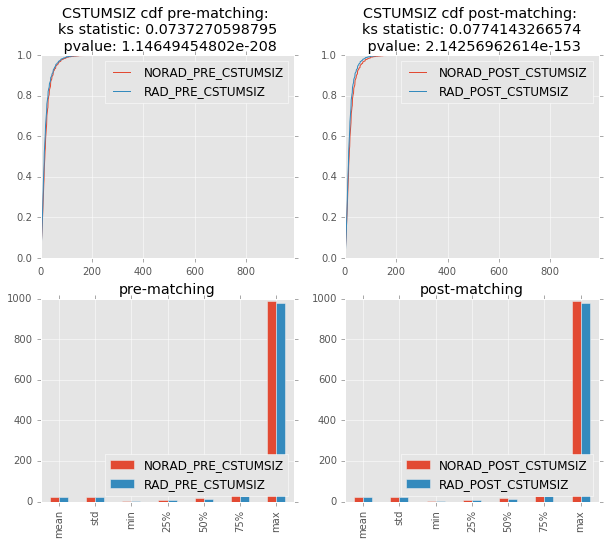

In [285]:
make_pre_post_plots('CSTUMSIZ')

I need to reindex ```dfbreast0``` so that treatment and control indices makes sense.

In [286]:
dfsmall.shape

(182509, 140)

In [287]:
dfsmall.index

Int64Index([ 7000091,  7000138,  7000314,  7000515,  7000790,  7000799,
             7001553,  7004464,  7004709,  7005175,
            ...
            41904546, 41905184, 41905920, 41906137, 41906138, 41906338,
            41906632, 41906810, 41906869, 41907414],
           dtype='int64', name='PUBCSNUM', length=182509)

In [288]:
dftreeleague.shape

(182509, 123)

In [292]:
dfsmall['League'] = dftreeleague['League']

In [289]:
def make_pre_post_plots_cat(columnname,df=dftreeleague,splitcolumn='League',
                       treatmentindices=treatmentindices,
                       controlindices=controlindices):
    """Takes a columnname and makes plots of the CDFs for the pre-matching and post-matching as
    well as makes plots of the summaries for the pre and postmatching cases."""
    
    from scipy import stats
    
    ALPOST = df[columnname][treatmentindices].value_counts(normalize=True).sort_index().cumsum()
    NLPOST = df[columnname][controlindices].value_counts(normalize=True).sort_index().cumsum()
    
    dfpost = pd.DataFrame({'NORAD_POST_' + columnname: ALPOST,
                           'RAD_POST_' + columnname: NLPOST})
    
    dfpost = dfpost.fillna(method='ffill')
    
    dfalpostdescribe = df[columnname][treatmentindices].value_counts(normalize=True).sort_index()
    dfnlpostdescribe = df[columnname][controlindices].value_counts(normalize=True).sort_index()
    
    dfpostdescribe = pd.DataFrame({'NORAD_POST_' + columnname: dfalpostdescribe,
                             'RAD_POST_' + columnname: dfnlpostdescribe})
    
    ALPRE = df[columnname][df[splitcolumn] == 1].value_counts(normalize=True).sort_index().cumsum()
    NLPRE = df[columnname][df[splitcolumn] == 0].value_counts(normalize=True).sort_index().cumsum()
    
    
    
    
    dfpre = pd.DataFrame({'NORAD_PRE_' + columnname: ALPRE,
                       'RAD_PRE_' + columnname: NLPRE})
    
    dfpre = dfpre.fillna(method='ffill')
    
    dfalpredescribe = df[columnname][df[splitcolumn] == 1].value_counts(normalize=True)
    dfnlpredescribe = df[columnname][df[splitcolumn] == 0].value_counts(normalize=True)
    
    dfpredescribe = pd.DataFrame({'NORAD_PRE_' + columnname: dfalpredescribe,
                             'RAD_PRE_' + columnname: dfnlpredescribe})
    
    ALPREvals = df[columnname][df[splitcolumn] == 1].values
    NLPREvals = df[columnname][df[splitcolumn] == 0].values
    ALPOSTvals = df[columnname][treatmentindices].values
    NLPOSTvals = df[columnname][controlindices].values
    
    preresults = stats.ks_2samp(ALPREvals, NLPREvals)
    postresults = stats.ks_2samp(ALPOSTvals, NLPOSTvals)
    
    f, axarr = plt.subplots(2,2,figsize=(10,8))
    
    ax = axarr[0, 0]
    titlepre = columnname +  ' cdf pre-matching: \n' + 'ks statistic: ' + \
    str(preresults.statistic) +'\n pvalue: ' + str(preresults.pvalue)
    dfpre.plot(title=titlepre ,ax=ax)
    ax.tick_params(labelbottom='off')
    
    titlepost = columnname +  ' cdf post-matching: \n' + 'ks statistic: ' + \
    str(postresults.statistic) +'\n pvalue: ' + str(postresults.pvalue)
    ax = axarr[0,1]
    dfpost.plot(title=titlepost,ax=ax)
    ax.tick_params(labelbottom='off')
    
    
    ax = axarr[1,0]
    ax = dfpredescribe.plot(kind='bar', title='pre-matching',
                      ax=ax)
    ax.legend(loc='upper right')
    
    
    ax = axarr[1,1]
    ax = dfpostdescribe.plot(kind='bar', title='post-matching',
                       ax=ax)
    ax.legend(loc='upper right')
    
    

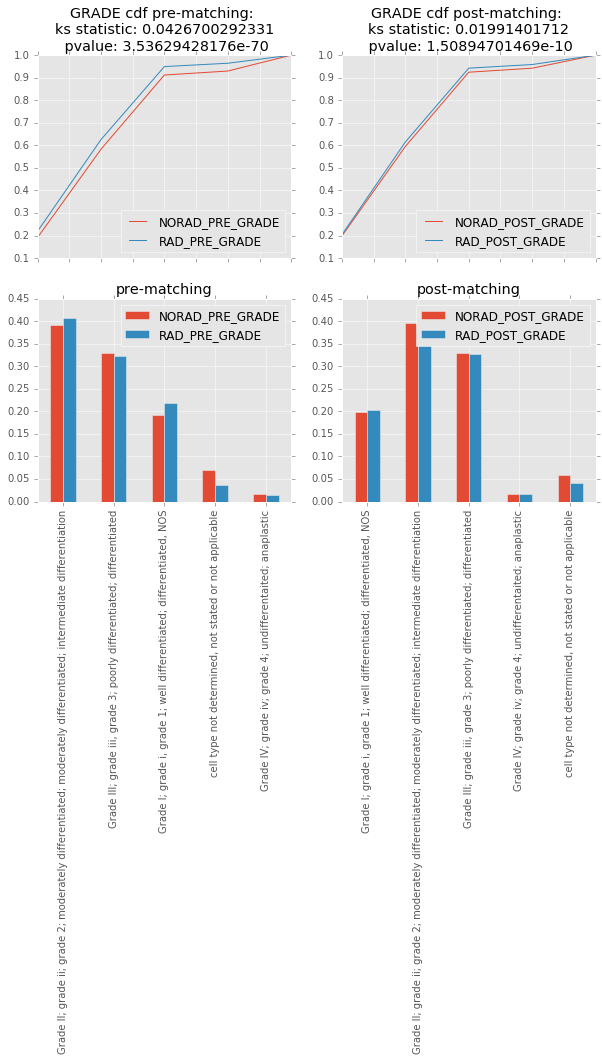

In [293]:
make_pre_post_plots_cat('GRADE',df=dfsmall)

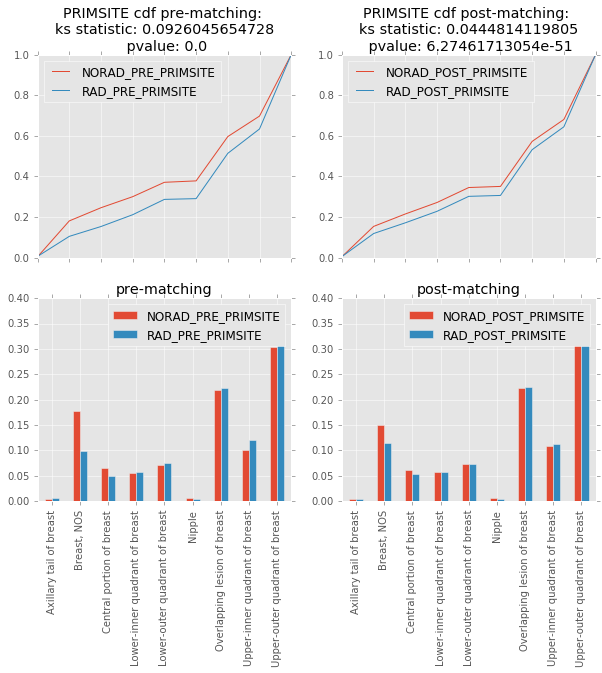

In [294]:
make_pre_post_plots_cat('PRIMSITE',df=dfsmall)

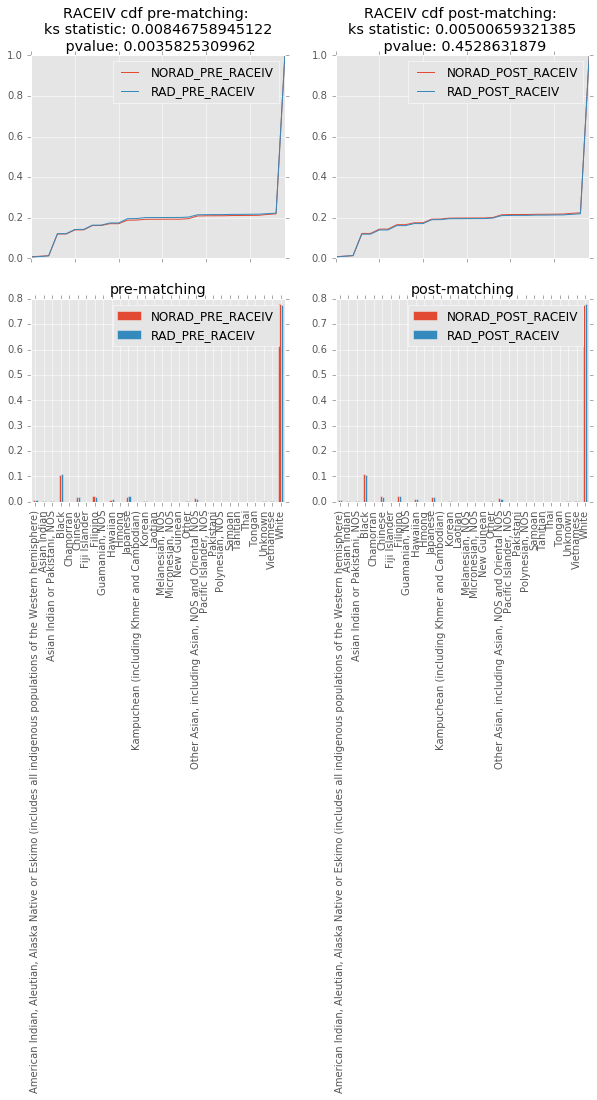

In [295]:
make_pre_post_plots_cat('RACEIV',df=dfsmall)

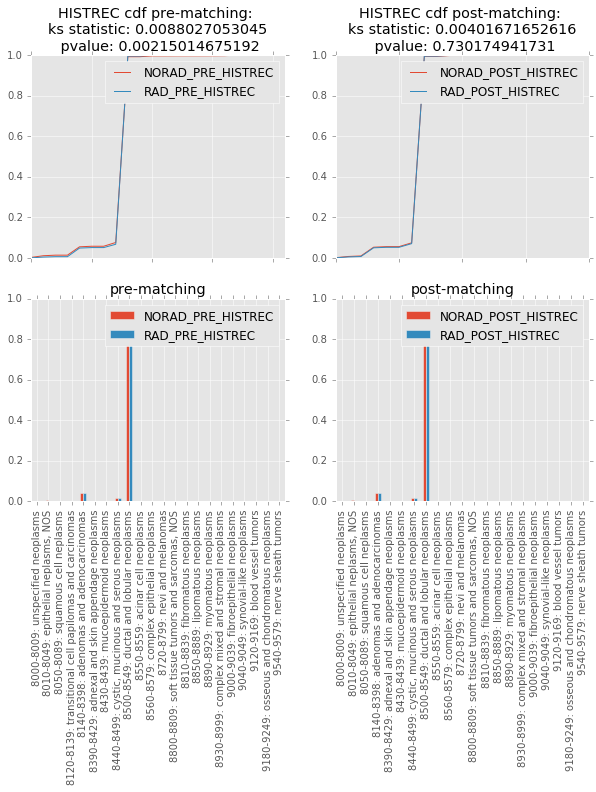

In [298]:
make_pre_post_plots_cat('HISTREC',df=dfsmall)

In [309]:
def make_stats_dataframe(df=dfsmall,splitcolumn='League',
                        treatmentindices=treatmentindices,
                        controlindices=controlindices):
    """Loops through all of the columns in df and retuns a new dataframe with the statistics of the
    pre and post matched cdfs for each column."""
    
    from scipy import stats
    
    total_dict = dict()
    
    for columnname in df.columns:
        try:
    
            ALPREvals = df[columnname][df[splitcolumn] == 1].values
            NLPREvals = df[columnname][df[splitcolumn] == 0].values
            ALPOSTvals = df[columnname][treatmentindices].values
            NLPOSTvals = df[columnname][controlindices].values
    
            preresults = stats.ks_2samp(ALPREvals, NLPREvals)
            postresults = stats.ks_2samp(ALPOSTvals, NLPOSTvals)
    
            statslist = [preresults.statistic, preresults.pvalue, 
                    postresults.statistic, postresults.pvalue]
        
            total_dict[columnname] = statslist
        except:
            pass
     
    dfstats = pd.DataFrame.from_dict(total_dict, orient='index')
    dfstats.columns = ['pre_ks_stat','pre_pvalue','post_ks_stat','post_pvalue']
    
    #dfstats.drop(['neighbor_1','neighbor_2','neighbor_3',
    #             'neighbor_1_League','neighbor_2_League','neighbor_3_League',
     #            'distance_1','distance_2','distance_3'],inplace=True)
    
    return dfstats

In [310]:
resgood['League'] = dfsmall['League']

In [311]:
dfsmall['YR_BRTH'] = dfsmall['YR_BRTH'].astype('int')
dfsmall['AGE_DX'] = dfsmall['AGE_DX'].astype('int')
dfsmall['CSTUMSIZ'] = dfsmall['CSTUMSIZ'].astype('float')
dfsmall['elevation'] = dfsmall['elevation'].astype('float')
dfsmall['lat'] = dfsmall['lat'].astype('float')
dfsmall['lng'] = dfsmall['lng'].astype('float')
dfsmall['srv_time_mon'] = dfsmall['srv_time_mon'].astype('float')

In [312]:
dfstats = make_stats_dataframe(df=dfsmall)
dfstats

,pre_ks_stat,pre_pvalue,post_ks_stat,post_pvalue
YEAR_DX,0.016972,1.845415e-11,0.021828,1.377476e-12
REPT_SRC,0.012731,1.234236e-06,0.014024,1.910254e-05
ANNARBOR,0.000000,1.000000e+00,0.000000,1.000000e+00
brst_sub,0.041314,8.146243e-66,0.028431,4.666044e-21
STAT_REC,0.079542,8.200439e-243,0.066768,3.257593e-114
CS11SITE,0.000000,1.000000e+00,0.000000,1.000000e+00
CS5SITE,0.027414,3.233355e-29,0.006537,1.621921e-01
RACEIV,0.008468,3.582531e-03,0.005007,4.528632e-01
ADJNM_6VALUE,0.023755,4.812842e-22,0.015476,1.540979e-06
AYASITERWHO,0.036254,8.899119e-51,0.020821,1.721043e-11
